In [2]:
%config InlineBackend.rc = {"figure.dpi": 150, "figure.figsize": (12.0, 8.0)}
%matplotlib widget

import abtem
import ase
import matplotlib.pyplot as plt
from ase.io import write
import jax
import jax.numpy as jnp
import numpy as np
from jax_multislice import forward_with_scan_positions, transmission_function, propagation_kernel, FresnelPropagator, move_probe
import optax
from tqdm.auto import tqdm


(examples:4d-stem_quickstart)=
# 4D-STEM quickstart

In [3]:
abtem.config.set({"device": "cpu"})

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

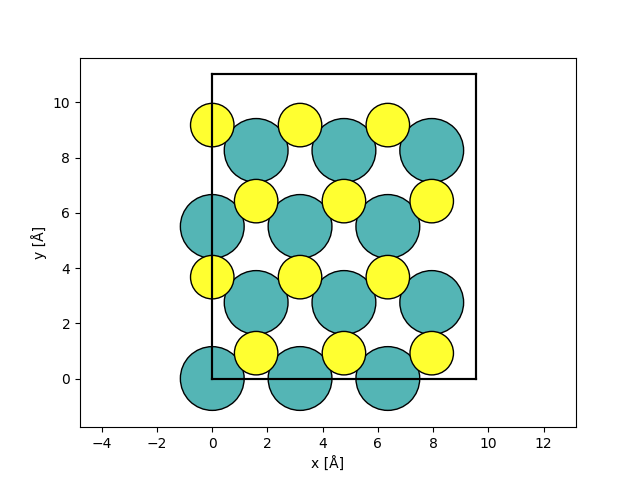

In [4]:
atoms = ase.build.mx2(vacuum=2)

atoms = abtem.orthogonalize_cell(atoms)

atoms *= (3, 2, 1)

abtem.show_atoms(atoms)

In [5]:
potential = abtem.Potential(atoms, sampling=0.1)


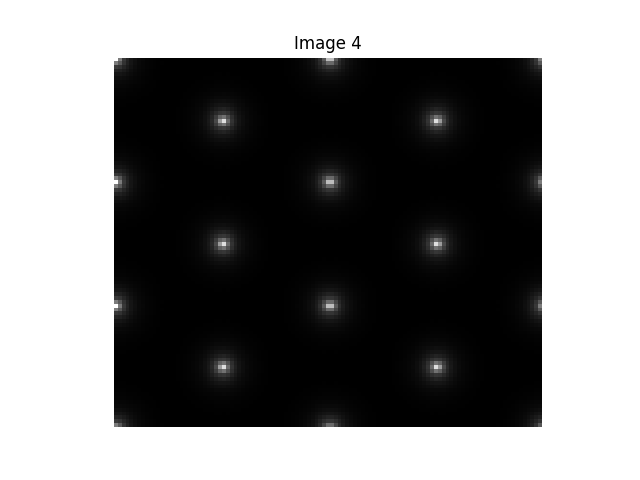

In [6]:
potential.shape
potential_ = potential.to_images()
img = potential_.array[4]

plt.figure()
plt.imshow((jnp.abs(jnp.array(img))), cmap='gray')
plt.title(f'Image {4}')
plt.axis('off')

plt.show()

In [7]:
energy = 80e3
probe = abtem.Probe(energy=energy, semiangle_cutoff=40)
probe.grid.match(potential)

pixels = probe.gpts
pixel_size = probe.sampling

In [8]:
grid_scan = abtem.GridScan(
    start=(0, 0),
    end=(potential.extent[0], potential.extent[1]),
    sampling=probe.aperture.nyquist_sampling,
)

In [9]:
detector = abtem.PixelatedDetector(max_angle='full')

measurements = probe.scan(potential, scan=grid_scan, detectors=detector)
probe_array = probe.build()

In [10]:
patterns = measurements.compute()
abtem_patterns = patterns.abs().array

[########################################] | 100% Completed | 5.28 sms


In [11]:
slice_thickness = jnp.array(potential.slice_thickness[0])
extent=jnp.array(potential.extent)
sampling=jnp.array(potential.sampling)
scan_positions = jnp.array(grid_scan.get_positions())
scan_positions_px = (scan_positions / sampling).astype(jnp.int32)
scan_positions_shape = scan_positions_px.shape[0:2]
slices = jnp.array(potential_.array)
probe = jnp.array(probe_array.array)

In [12]:
n, m = slices.shape[1::]
scan_positions_px = scan_positions_px.reshape(-1, 2)
H = propagation_kernel(n, m, sampling, slice_thickness, energy)

def forward(slices, scan_position_px):
    probe_shifted = move_probe(probe, scan_position_px)
    exit_wave = probe_shifted * slices[0]
    
    def body_fun(i, exit_wave):
        exit_wave = FresnelPropagator(exit_wave, H)
        exit_wave = exit_wave * slices[i]
        return exit_wave

    exit_wave = jax.lax.fori_loop(1,
                                  slices.shape[0],
                                  body_fun,
                                  exit_wave)

    diffraction_pattern = jnp.abs(jnp.fft.fftshift(jnp.fft.fft2(exit_wave)))
    return diffraction_pattern

forward = jax.jit(forward)

def _forward(slices):

    transmission = transmission_function(slices, energy)

    diffraction_patterns = jax.vmap(lambda pos: forward(transmission, pos))(scan_positions_px)
    diffraction_patterns = diffraction_patterns.reshape((*scan_positions_shape, n, m))
    return diffraction_patterns


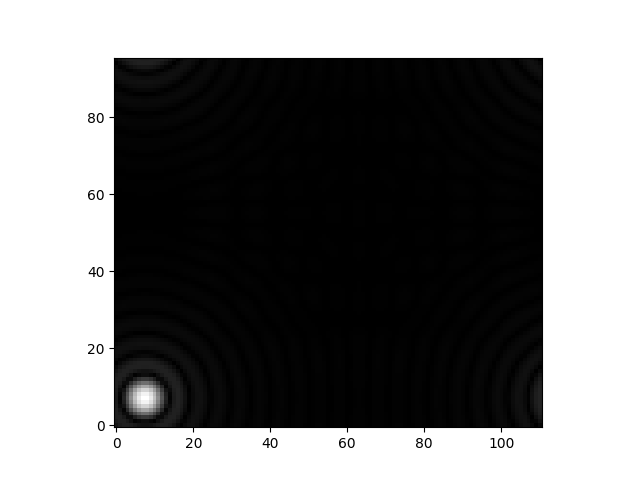

In [16]:
probe_shifted = move_probe(probe, [0, 0])
exit_wave = probe_shifted * slices[0]

plt.figure()
plt.imshow(jnp.abs(probe_shifted), cmap='gray', origin='lower')
plt.show()


Traced<ShapedArray(int32[2])>with<DynamicJaxprTrace>


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[96,111]
The error occurred while tracing the function forward at /tmp/ipykernel_4157523/3941716274.py:5 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:c64[96,111] = pjit[
  name=_roll_dynamic
  jaxpr={ lambda ; b:c64[96,111] c:i32[2]. let
      d:i32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=(1,)] c
      e:i32[] = squeeze[dimensions=(0,)] d
      f:i32[] = max 96 1
      g:i32[] = pjit[
        name=remainder
        jaxpr={ lambda ; h:i32[] i:i32[]. let
            j:bool[] = eq i 0
            k:i32[] = pjit[
              name=_where
              jaxpr={ lambda ; l:bool[] m:i32[] n:i32[]. let
                  o:i32[] = select_n l n m
                in (o,) }
            ] j 1 i
            p:i32[] = rem h k
            q:bool[] = ne p 0
            r:bool[] = lt p 0
            s:bool[] = lt k 0
            t:bool[] = ne r s
            u:bool[] = and t q
            v:i32[] = add p k
            w:i32[] = select_n u p v
          in (w,) }
      ] e f
      x:c64[192,111] = concatenate[dimension=0] b b
      y:i32[] = sub 96 g
      z:bool[] = lt y 0
      ba:i32[] = add y 192
      bb:i32[] = select_n z y ba
      bc:i32[] = add 0 111
      bd:i32[] = select_n False 0 bc
      be:c64[96,111] = dynamic_slice[slice_sizes=(96, 111)] x bb bd
      bf:i32[1] = slice[limit_indices=(2,) start_indices=(1,) strides=(1,)] c
      bg:i32[] = squeeze[dimensions=(0,)] bf
      bh:i32[] = max 111 1
      bi:i32[] = pjit[
        name=remainder
        jaxpr={ lambda ; h:i32[] i:i32[]. let
            j:bool[] = eq i 0
            k:i32[] = pjit[
              name=_where
              jaxpr={ lambda ; l:bool[] m:i32[] n:i32[]. let
                  o:i32[] = select_n l n m
                in (o,) }
            ] j 1 i
            p:i32[] = rem h k
            q:bool[] = ne p 0
            r:bool[] = lt p 0
            s:bool[] = lt k 0
            t:bool[] = ne r s
            u:bool[] = and t q
            v:i32[] = add p k
            w:i32[] = select_n u p v
          in (w,) }
      ] bg bh
      bj:c64[96,222] = concatenate[dimension=1] be be
      bk:i32[] = sub 111 bi
      bl:i32[] = add 0 96
      bm:i32[] = select_n False 0 bl
      bn:bool[] = lt bk 0
      bo:i32[] = add bk 222
      bp:i32[] = select_n bn bk bo
      bq:c64[96,111] = dynamic_slice[slice_sizes=(96, 111)] bj bm bp
    in (bq,) }
] br bs
    from line /home/dl277493/Documents/Code/DifferentialPtychography/jax_multislice.py:87:11 (move_probe)

  operation a:f32[96,111] = abs b
    from line /tmp/ipykernel_4157523/3941716274.py:11:15 (forward)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

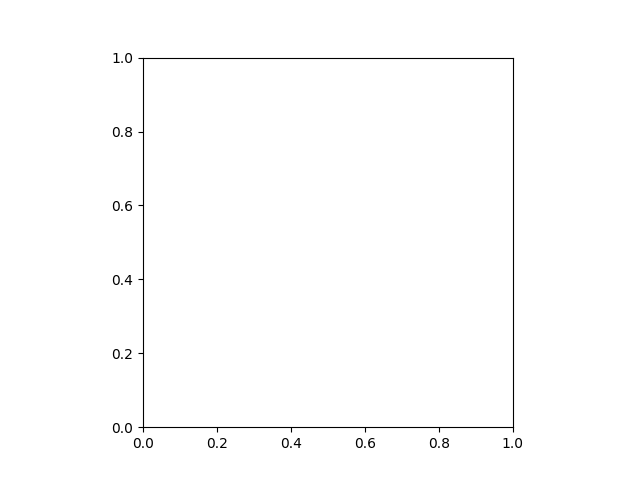

In [13]:
jax_patterns = _forward(slices)

scan_position_x, scan_position_y = 20, 16
fig, ax = plt.subplots(1, 2)
ax[0].imshow(jnp.abs(jax_patterns[scan_position_x, scan_position_y]), cmap='gray')
ax[1].imshow(abtem_patterns[scan_position_x, scan_position_y], cmap='gray')
ax[0].set_title('JAX')
ax[1].set_title('ABTEM')

In [ ]:

def loss(slices):
    jax_patterns = _forward(slices)
    return jnp.sum(jnp.abs(jax_patterns - abtem_patterns)**2)


opt_slices = jnp.ones_like(potential_.array, dtype=jnp.complex64)

learning_rate = 1e-2
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_slices)

def update(slices, opt_state):
    loss_val, grads = jax.value_and_grad(loss)(slices)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_slices = optax.apply_updates(slices, updates)
    return new_slices, new_opt_state, loss_val

num_steps = 1000

losses = []
for step in tqdm(range(num_steps)):
    opt_slices, opt_state, current_loss = update(opt_slices, opt_state)
    print(f"Step {step}, loss: {current_loss}")
    losses.append(current_loss)
    
optimized_slices = opt_slices

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 0, loss: 1415.68505859375
Step 1, loss: 1415.927001953125
Step 2, loss: 1416.170166015625
Step 3, loss: 1416.410888671875
Step 4, loss: 1416.654296875
Step 5, loss: 1416.8948974609375
Step 6, loss: 1417.138427734375
Step 7, loss: 1417.3790283203125
Step 8, loss: 1417.62255859375
Step 9, loss: 1417.8662109375
Step 10, loss: 1418.10693359375
Step 11, loss: 1418.350830078125
Step 12, loss: 1418.5916748046875
Step 13, loss: 1418.838134765625
Step 14, loss: 1419.0791015625
Step 15, loss: 1419.3231201171875
Step 16, loss: 1419.564208984375
Step 17, loss: 1419.80810546875
Step 18, loss: 1420.0491943359375
Step 19, loss: 1420.293212890625
Step 20, loss: 1420.537109375
Step 21, loss: 1420.7811279296875
Step 22, loss: 1421.0224609375
Step 23, loss: 1421.266845703125
Step 24, loss: 1421.510986328125
Step 25, loss: 1421.7523193359375
Step 26, loss: 1421.99658203125
Step 27, loss: 1422.24072265625
Step 28, loss: 1422.485107421875
Step 29, loss: 1422.7266845703125
Step 30, loss: 1422.9711914062